<!-- Do NOT edit the Markdown file directly - generated from the Jupyter notebook. -->

# Tumoroscope in PyMC

[![python](https://img.shields.io/badge/Python-3.9+-3776AB.svg?style=flat&logo=python&logoColor=white)](https://www.python.org)
[![Pytest](https://github.com/jhrcook/tumoroscope-pymc/actions/workflows/pytest.yaml/badge.svg)](https://github.com/jhrcook/tumoroscope-pymc/actions/workflows/pytest.yaml)
[![Code style: black](https://img.shields.io/badge/code%20style-black-000000.svg)](https://github.com/psf/black)
[![pre-commit](https://img.shields.io/badge/pre--commit-enabled-brightgreen?logo=pre-commit&logoColor=white)](https://github.com/pre-commit/pre-commit)
[![Checked with mypy](http://www.mypy-lang.org/static/mypy_badge.svg)](http://mypy-lang.org/)
[![pydocstyle](https://img.shields.io/badge/pydocstyle-enabled-AD4CD3)](http://www.pydocstyle.org/en/stable/)
[![License: GPLv3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0)

This package builds the ['Tumoroscope'](https://www.biorxiv.org/content/10.1101/2022.09.22.508914v1) (Shafighi *et al.*, 2022, bioRxiv preprint) model with the probabilistic programming library [PyMC](https://www.pymc.io/welcome.html).
'Tumoroscope' is a "probabilistic model that accurately infers cancer clones and their high-resolution localization by integrating pathological images, whole exome sequencing, and spatial transcriptomics data."

![Tumoroscope diagram](https://raw.githubusercontent.com/jhrcook/tumoroscope-pymc/master/tumoroscope-diagram.jpeg)

## Installation

> As this package provides a model produced using PyMC, I recommend first creating a virtual environment using `conda` and installing the PyMC library.
> You can follow their instructions [here](https://www.pymc.io/projects/docs/en/latest/installation.html).

You can install this package using `pip` either from PyPI

```bash
pip install tumoroscope-pymc
```

or from GitHub

```
pip install git+https://github.com/jhrcook/tumoroscope-pymc.git
```

## Background

Below is the abstract of the paper the introduced the 'Tumoroscope' package:

> Spatial and genomic heterogeneity of tumors is the key for cancer progression, treatment, and survival. However, a technology for direct mapping the clones in the tumor tissue based on point mutations is lacking. Here, we propose Tumoroscope, the first probabilistic model that accurately infers cancer clones and their high-resolution localization by integrating pathological images, whole exome sequencing, and spatial transcriptomics data. In contrast to previous methods, Tumoroscope explicitly addresses the problem of deconvoluting the proportions of clones in spatial transcriptomics spots. Applied to a reference prostate cancer dataset and a newly generated breast cancer dataset, Tumoroscope reveals spatial patterns of clone colocalization and mutual exclusion in sub-areas of the tumor tissue. We further infer clone-specific gene expression levels and the most highly expressed genes for each clone. In summary, Tumoroscope enables an integrated study of the spatial, genomic, and phenotypic organization of tumors.

Shadi Darvish Shafighi, Agnieszka Geras, Barbara Jurzysta, Alireza Sahaf Naeini, Igor Filipiuk, Łukasz Rączkowski, Hosein Toosi, Łukasz Koperski, Kim Thrane, Camilla Engblom, Jeff Mold, Xinsong Chen, Johan Hartman, Dominika Nowis, Alessandra Carbone, Jens Lagergren, Ewa Szczurek. "Tumoroscope: a probabilistic model for mapping cancer clones in tumor tissues." *bioRxiv*. 2022.09.22.508914; doi: https://doi.org/10.1101/2022.09.22.508914


## Use

> *If viewing this package on PyPI, I apologize, but all images below are not viewable.
> Please click on "Home" in the sidebar or [here](https://github.com/jhrcook/tumoroscope-pymc) to go to the GitHub repository to see the full demonstration of this package.*

Below is a simple example of using this library.
A small dataset is simulated and used to construct the Tumoroscope model in PyMC.
The "Inference Button" of PyMC is then used to sample from the posterior distribution.

First all of the necessary imports for this example are below.

In [1]:
from math import ceil
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from tumoroscope import TumoroscopeData, build_tumoroscope_model
from tumoroscope.mock_data import generate_simulated_data

In [2]:
# %matplotlib inline
%config InlineBackend.figure_format='retina'

### Simulated data

The input to `build_tumoroscope_model()` is a `TumoroscopeData` object.
This object contains all of the data size parameters, model hyperparameters, and the observed data.
It also has a `validate()` method for checking basic assumptions about the values and data.
Below is an example of constructing a `TumoroscopeData` object with random data.

In [3]:
TumoroscopeData(
    K=5,
    S=10,
    M=100,
    F=np.ones(5) / 5,
    cell_counts=np.random.randint(1, 20, size=10),
    C=np.random.beta(2, 2, size=(100, 5)),
    D_obs=np.random.randint(2, 20, size=(100, 10)),
    A_obs=np.random.randint(2, 20, size=(100, 10)),
)

Tumoroscope Data
 Data sizes:
   K: 5  S: 10  M: 100
 Hyperparameters:
   zeta_s: 1.0  F_0: 1.0  l: 100  r: 0.1  p: 1.0
 Counts data:
   D: provided  A: provided

For this example, we'll use the provided `generate_simulated_data()` function to create a dataset with 5 clones, 10 spatial transcriptomic spots, and up to 50 mutation positions.
In this data-generation function, the number of reads per cell per mutation position are randomly sampled from a Poisson distribution.
Here, I have provided a relatively high rate of $\lambda = 2.5$ to ensure the read coverage is very high for demonstration purposes of Tumoroscope.
The default value, though, provides more realistic read coverage for a good spatial transcriptomic study.
This function returns a `SimulatedTumoroscopeData` object containing the true underlying data (including a table of cell labels in each spot) and the input `TumoroscopeData` object as the `sim_data` attribute.

In [4]:
simulation = generate_simulated_data(
    K=5, S=10, M=50, total_read_rate=2.5, random_seed=8
)
simulation.sim_data.validate()
simulation.true_labels.head()

,spot,cell,clone
0,0,0,2
1,0,1,0
2,0,2,3
3,0,3,1
4,1,0,0


Below is a visualization of the cells in each spot.
The spots are represented by the horizontally-arrange boxes and each point is a cell, colored by its clone label.
To be clear, this information is only known because we simulated the data and the point of 'Tumoroscope' is to figure out these labels.

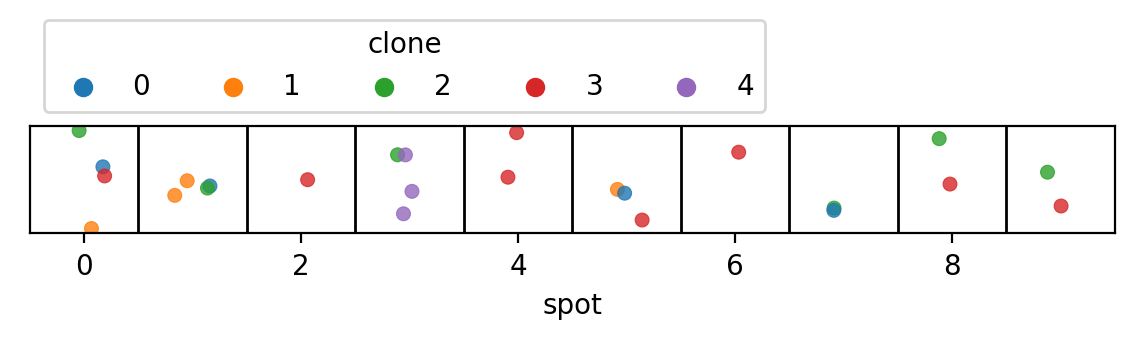

In [5]:
np.random.seed(3)
plot_df = (
    simulation.true_labels.copy()
    .assign(
        y=lambda d: np.random.normal(0, 0.5, len(d)),
        x=lambda d: d["spot"] + np.random.uniform(-0.2, 0.2, len(d)),
    )
    .astype({"clone": "category"})
)
_, ax = plt.subplots(figsize=(7, 0.7))
sns.scatterplot(
    data=plot_df, x="x", y="y", hue="clone", ax=ax, alpha=0.8, edgecolor=None, s=25
)
for i in range(1, simulation.sim_data.S):
    ax.axvline(i - 0.5, lw=1, color="k")
ax.set_xlim(-0.5, simulation.sim_data.S - 0.5)
ax.set_xlabel("spot")
ax.set_ylabel(None)
ax.set_yticks([])
ax.legend(
    loc="lower left", bbox_to_anchor=(0, 1), title="clone", ncol=simulation.sim_data.K
)
plt.show()

Below are the mutations assigned to each clone.
In real-world applications, this information comes from the bulk DNA data.
The zygosity of each mutation for each clone is also known (not shown here).

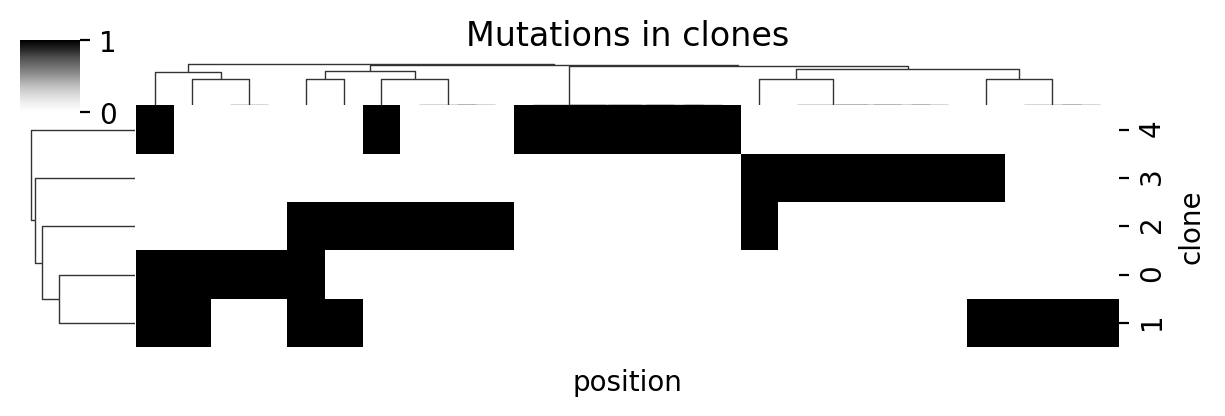

In [6]:
cg = sns.clustermap(
    simulation.clone_mutations.T,
    figsize=(6, 2),
    dendrogram_ratio=(0.1, 0.15),
    cmap="Greys",
)
cg.ax_heatmap.set_xlabel("position")
cg.ax_heatmap.set_ylabel("clone")
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.tick_params("x", size=0)
cg.ax_col_dendrogram.set_title("Mutations in clones")
plt.show()

Finally, the heatmaps below show the total read counts (left) and number of alternative read counts (right) per spot and mutation position.
This is the data gathered from the spatial transcriptomics.

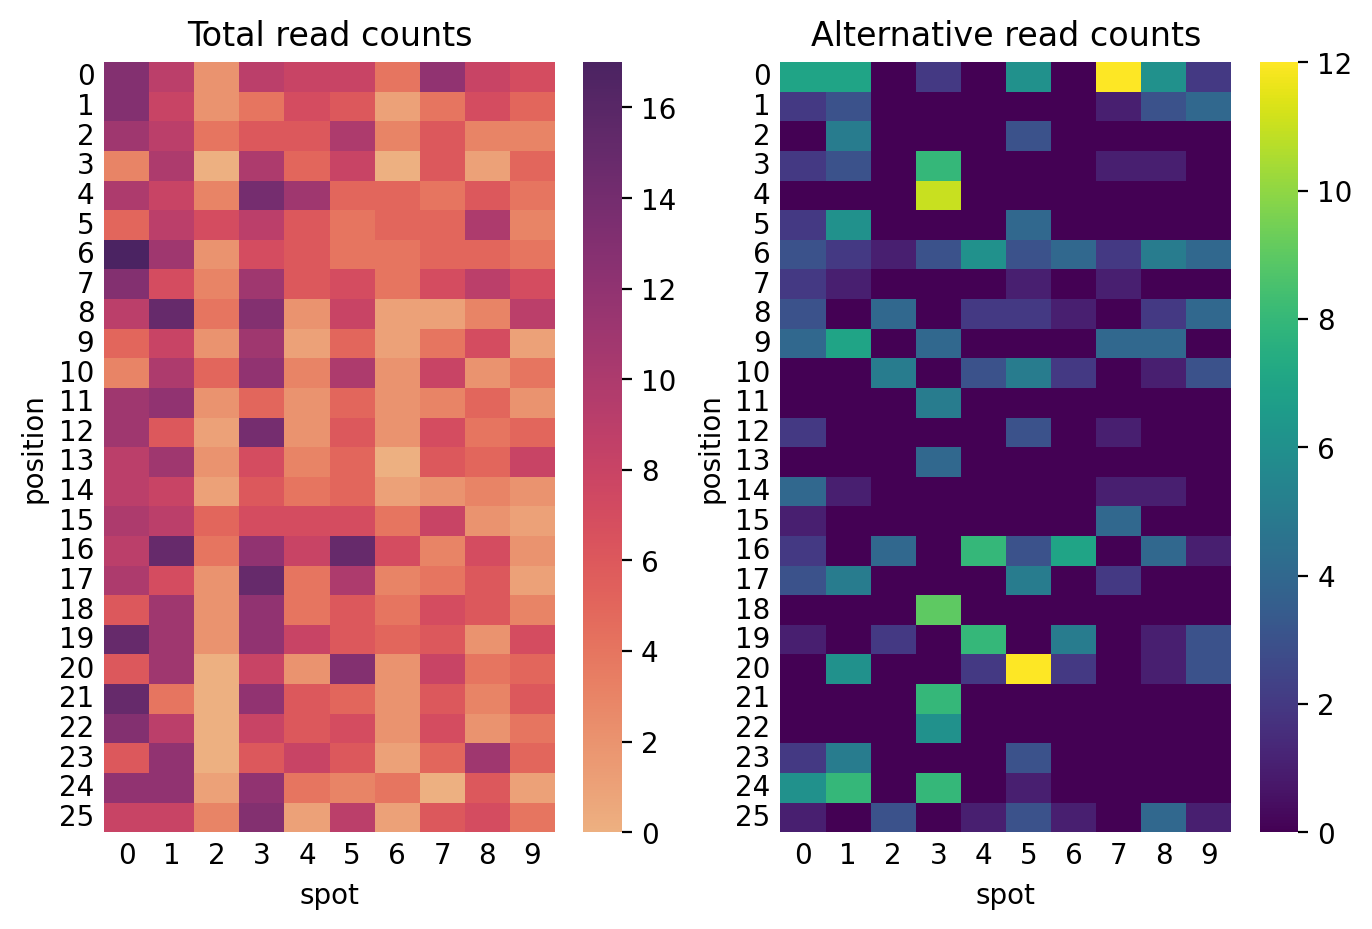

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
sns.heatmap(simulation.sim_data.D_obs, cmap="flare", ax=axes[0])
axes[0].set_title("Total read counts")
sns.heatmap(simulation.sim_data.A_obs, cmap="viridis", ax=axes[1])
axes[1].set_title("Alternative read counts")

for ax in axes:
    ax.tick_params(size=0)
    ax.set_xlabel("spot")
    ax.set_ylabel("position")

plt.show()

### Model

The model is built by passing a `TumoroscopeData` object to the `build_tumoroscope_model()` function.
This function has other arguments including the option for wether to use the "fixed" form of the model where the number of cells per position is assumed to be accurately known.
As in the paper, the "unfixed" form of the model is default (i.e. `fixed = False`).
By default, the input data is validated, though this can be skipped incase I have applied incorrect assumptions to the data (if you believe this is a the case, please open an [Issue](https://github.com/jhrcook/tumoroscope-pymc/issues) so I can adjust the validation method.)

Below, I build the model with the simulated data and show the model structure.

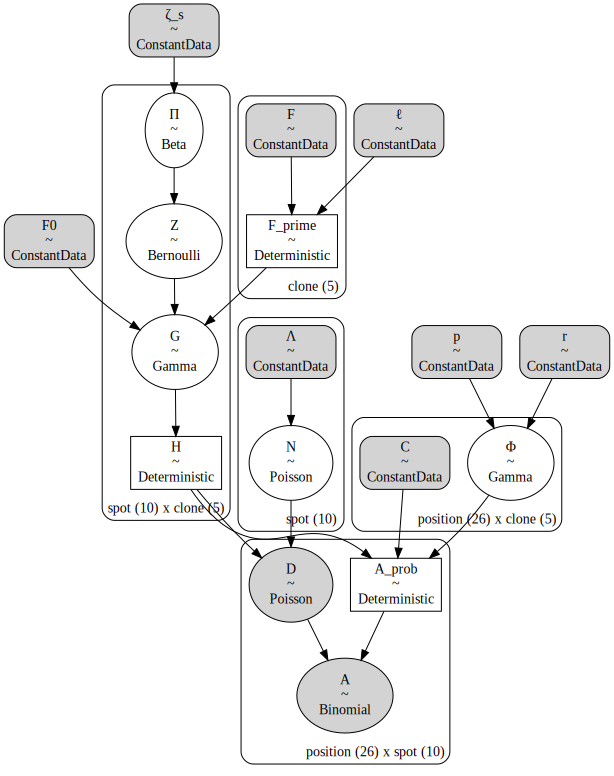

In [8]:
tumoroscope_model = build_tumoroscope_model(simulation.sim_data)
pm.model_to_graphviz(tumoroscope_model)

With the model built, we can sample from the posterior distribution using PyMC's "Inference Button": `pm.sample()`.
To make development easier, I have cached the posterior trace object, but sampling for this simulation originally took about 5 minutes.

In [9]:
cache_fp = Path(".cache") / "tumoroscope-simulation-example.netcdf"
if not cache_fp.parent.exists():
    cache_fp.parent.mkdir()

if cache_fp.exists():
    print("Retrieving from cache.")
    trace = az.from_netcdf(cache_fp)
else:
    with tumoroscope_model:
        trace = pm.sample(500, tune=500, chains=2, cores=2, random_seed=7)
        _ = pm.sample_posterior_predictive(
            trace, extend_inferencedata=True, random_seed=7
        )
    trace.to_netcdf(cache_fp)

Retrieving from cache.


### Posterior analysis

We can now inspect the model's results.
(Of course you would also want to conduct various diagnostic checks on the MCMC sampling process, but I have skipped that here.)
We can look at the estimates for the proportion of each clone in each spot of the spatial transcriptomics by inspecting $H$.

In [10]:
h_post = az.summary(trace, var_names=["H"])
h_post.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"H[s0, c0]",0.399,0.067,0.281,0.527,0.005,0.004,157.0,412.0,1.00
"H[s0, c1]",0.121,0.051,0.041,0.226,0.004,0.003,199.0,309.0,1.01
"H[s0, c2]",0.267,0.060,0.162,0.379,0.005,0.003,156.0,521.0,1.02
"H[s0, c3]",0.177,0.046,0.092,0.258,0.003,0.002,295.0,561.0,1.01
"H[s0, c4]",0.036,0.033,0.000,0.094,0.002,0.001,315.0,538.0,1.01


The plot below shows the posterior distribution for the estimated proportion of the cells in each spot that belong to each clone.

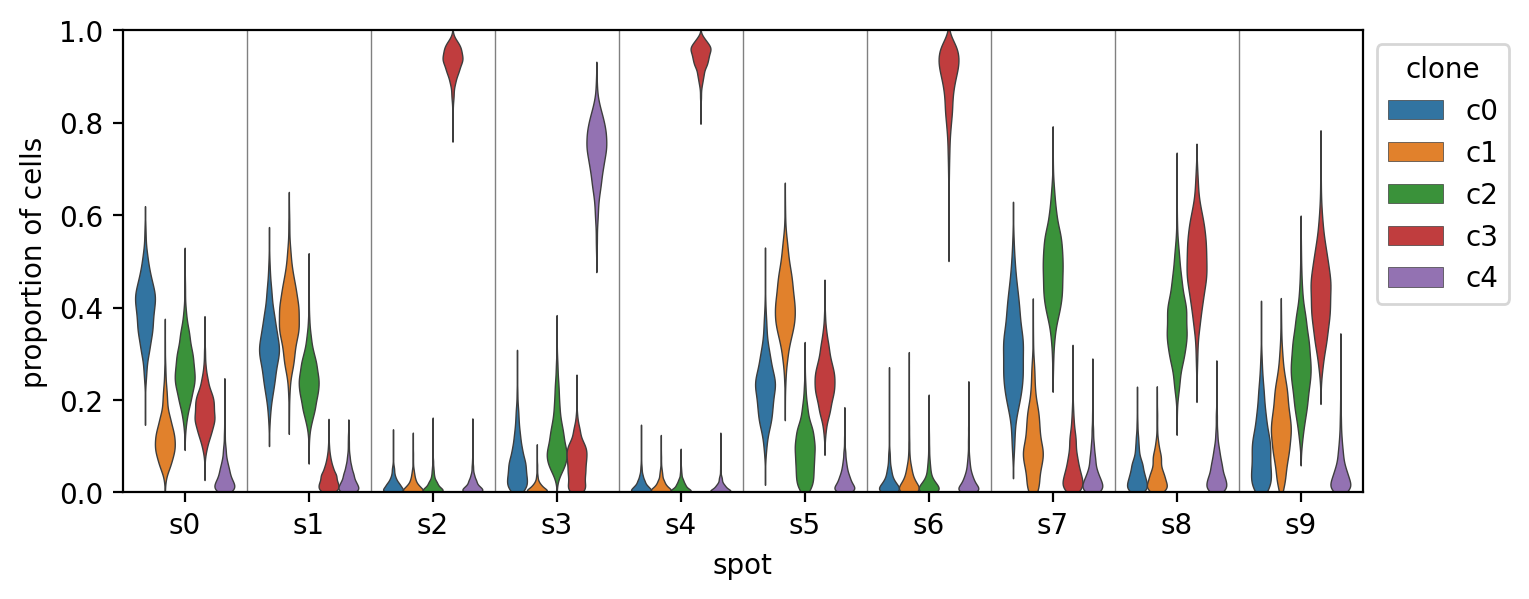

In [11]:
h_post = trace.posterior["H"].to_dataframe().reset_index()
_, ax = plt.subplots(figsize=(8, 3))
sns.violinplot(
    data=h_post,
    x="spot",
    y="H",
    hue="clone",
    dodge=True,
    scale="width",
    inner=None,
    linewidth=0.5,
    ax=ax,
)
ax.set_ylim(0, 1)
for i in range(simulation.sim_data.S):
    ax.axvline(i + 0.5, c="grey", lw=0.5)

ax.set_xlabel("spot")
ax.set_ylabel("proportion of cells")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="clone")
plt.show()

And finally, we can compare the model's estimates (in red for each chain with mean and 89% HDI)v against the known proportions in each spot (blue).
In this case, the model was quite successful.

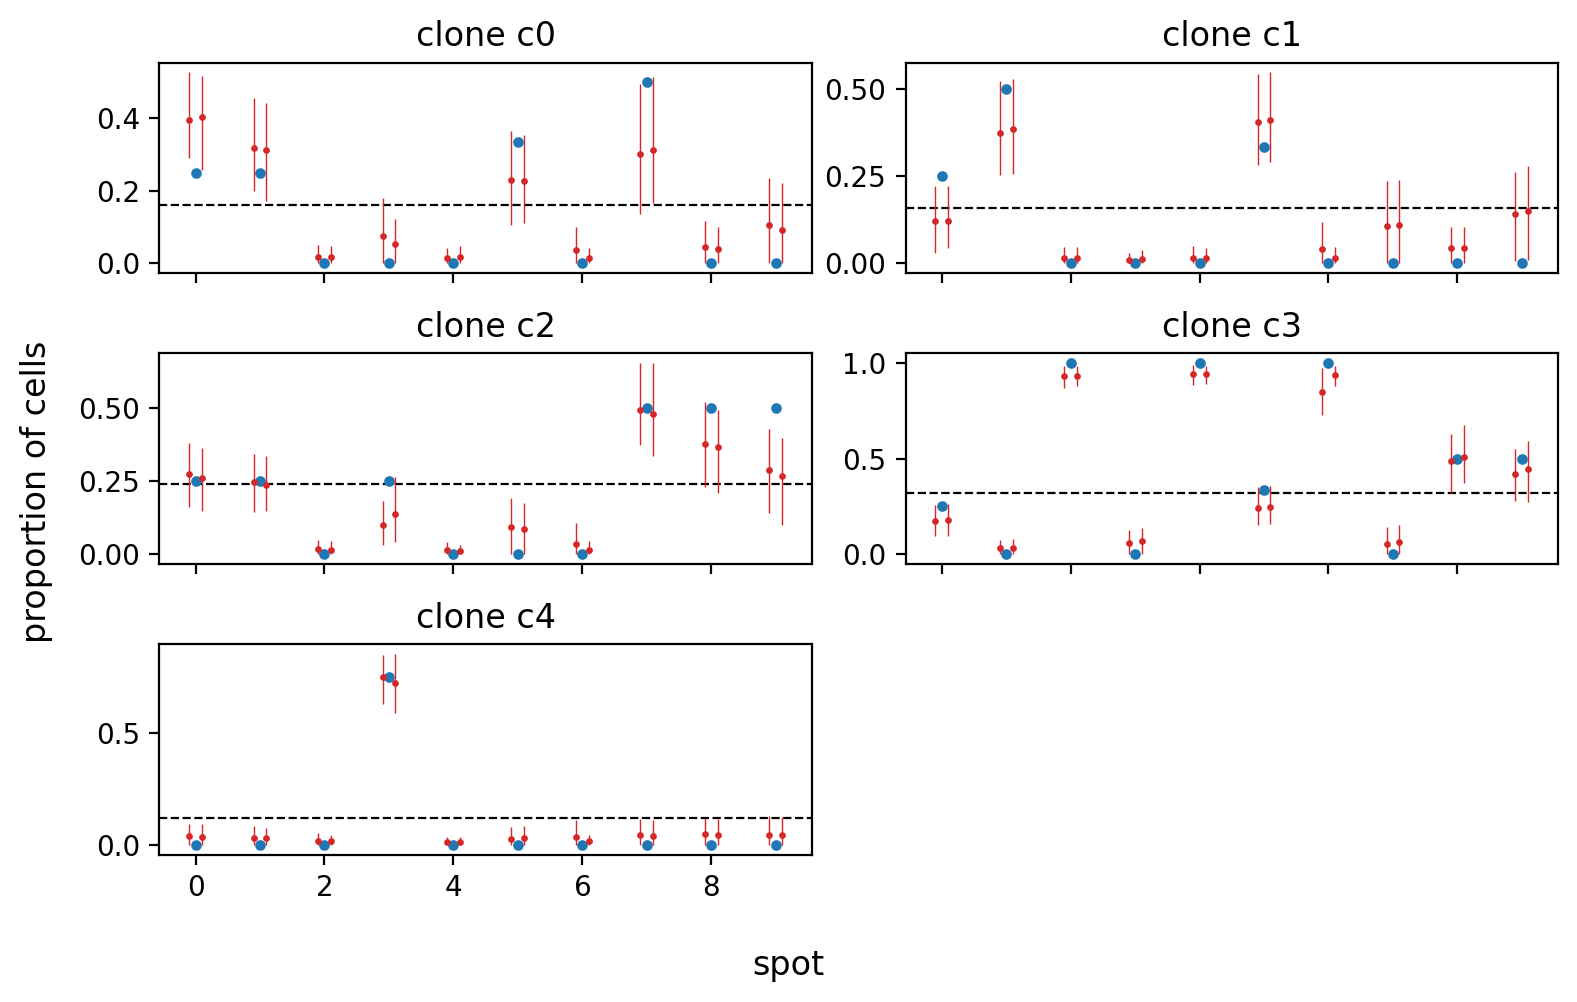

In [12]:
def frac_clone(s: pd.Series, k: int) -> float:
    """Fraction of cells in `s` that are clone `k`."""
    return np.mean(s == k)


fig, axes = plt.subplots(
    nrows=ceil(simulation.sim_data.K / 2),
    ncols=2,
    figsize=(8, 1 * simulation.sim_data.K),
    sharex=True,
)
for ax, clone_i in zip(axes.flatten(), range(simulation.sim_data.K)):
    clone = f"c{clone_i}"
    ax.set_title(f"clone {clone}")

    # Plot true fraction of clones at each spot.
    true_clone_frac = simulation.true_labels.groupby(["spot"])["clone"].apply(
        frac_clone, k=clone_i
    )
    ax.scatter(
        true_clone_frac.index.tolist(),
        true_clone_frac.values.tolist(),
        c="tab:blue",
        s=8,
        zorder=10,
    )

    # Plot population fraction.
    ax.axhline(simulation.sim_data.F[clone_i], lw=0.8, c="k", ls="--")

    # Plot posterior.
    H = trace.posterior["H"].sel(clone=[clone])
    dx = np.linspace(-0.1, 0.1, len(H.coords["chain"]))
    spot = np.arange(simulation.sim_data.S)
    for chain in H.coords["chain"]:
        _x = spot + dx[chain]
        ax.scatter(_x, H.sel(chain=chain).mean(axis=(0)), c="tab:red", s=2, zorder=20)
        _hdi = az.hdi(H, coords={"chain": [chain]})["H"].values.squeeze()
        ax.vlines(
            x=_x, ymin=_hdi[:, 0], ymax=_hdi[:, 1], lw=0.5, zorder=10, color="tab:red"
        )
    # ax.set_ylabel("proportion of cells")
    ax.set_ylabel(None)
    ax.set_xlabel(None)

fig.supxlabel("spot", va="bottom")
fig.supylabel("proportion of cells")

for ax in axes.flatten()[simulation.sim_data.K :]:
    ax.axis("off")

fig.tight_layout()
plt.show()

## Development

The development environment can be set up with `conda` (or faster using `mamba`).
This will handle the installation of PyMC better than using `pip`.

```bash
mamba env create -f conda.yaml
conda activate tumoroscope-pymc
```

The test suite can be run manually using the `pytest` command or using `tox` which also manages the test environment.

```bash
tox
```

This README is built from a Jupyter notebook and can be re-executed and converted to Markdown using another `tox` command.

```bash
tox -e readme
```

Feature requests and bugs are welcome in [Issues](https://github.com/jhrcook/tumoroscope-pymc/issues) and contributions are also welcome.

---

## Environment information


In [13]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-25

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: master

pandas    : 1.5.1
numpy     : 1.23.4
pymc      : 4.2.2
matplotlib: 3.6.1
seaborn   : 0.12.0
arviz     : 0.13.0

